# Task-4 - Decomposition

### by Musfar Muhamed Kozhikkal

A common challenge in the design and implementation of quantum circuits is that they become too extensive and complex due to the large number of qubits required. 

The number of quantum operations and the interdependence between qubits can further complicate the problem, making some traditional optimization methods ineffective or insufficient for reducing the complexity. Additionally, as the number of qubits increases, the fidelity of the circuit may be affected, which implies a greater need for advanced techniques to maintain the precision of operations.

On the other hand, some quantum computing frameworks offer predefined optimization methods that may seem like a convenient option. However, they are not always the best alternative if one has a deep understanding of the quantum hardware structure. Customizing the circuits by taking advantage of the specific features of the quantum device in use can result in a more efficient design, better adapted to the physical limitations of the system. Therefore, having a solid understanding of the hardware can make the difference between a generic quantum circuit and one that is highly optimized for performance.

## Challenge:
Consider the following code as input

In [1]:
import numpy as np
size = 5
state_values = [22,17,27,12]
state_vector = [0]*2**size
for s in state_values:
    print(np.binary_repr(s,size))
    state_vector[s] = 0.5
np.asarray(state_vector)

10110
10001
11011
01100


array([0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0.5,
       0. , 0. , 0. , 0. , 0.5, 0. , 0. , 0. , 0. , 0.5, 0. , 0. , 0. ,
       0. , 0.5, 0. , 0. , 0. , 0. ])

Find a quantum circuit that represents the state vector with a depth less than 50, using the basis_gates=[x,h,rz,cx] and the following architecture
![image.png](attachment:a9fcd9a4-ec1d-4d64-914a-05806c123073.png)!

#### import necessary libraries

In [2]:
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit, transpile
from qiskit.primitives import StatevectorSampler
from qiskit.visualization import plot_histogram, plot_circuit_layout
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit.transpiler.preset_passmanagers.plugin import list_stage_plugins
from qiskit_ibm_runtime.fake_provider import FakeYorktownV2

#### see how to make these states individually

In [3]:
n = 5  
state_vec=[[0,2,3],[0,4],[0,1,3,4],[1,2]]
desired_states = ['10110', '10001', '11011', '01100']
for i in state_vec:
    qc = QuantumCircuit(n)
    qc.x(i)
    qc.measure_all()
    sampler = StatevectorSampler()
    pub = (qc)
    job_sampler = sampler.run([pub])
    result_sampler = job_sampler.result()
    counts_sampler = result_sampler[0].data.meas.get_counts()
    print(counts_sampler)

{'01101': 1024}
{'10001': 1024}
{'11011': 1024}
{'00110': 1024}


#### Make quantum circuit with intial states as your desired state

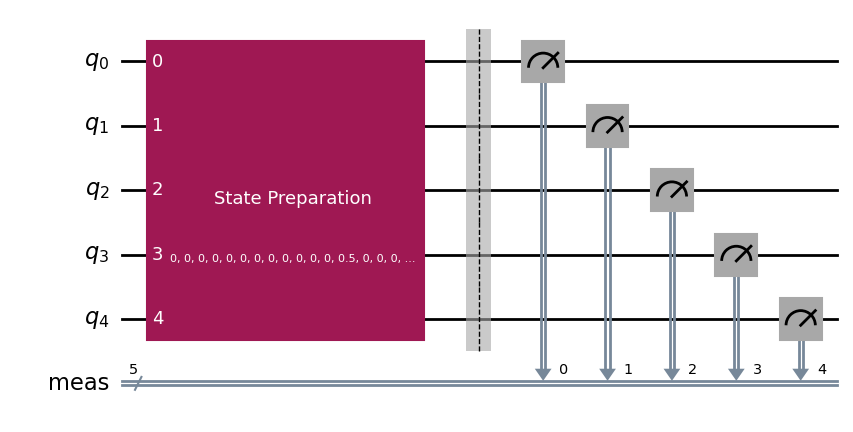

In [4]:
qc = QuantumCircuit(n)
qc.prepare_state(state_vector, [0, 1, 2, 3, 4])
qc.measure_all()
qc.draw('mpl')

#### run the circuit and check whether it gives the correct states

simulated state : {'10110': 266, '10001': 241, '01100': 272, '11011': 245}
desired state : ['10110', '10001', '11011', '01100']


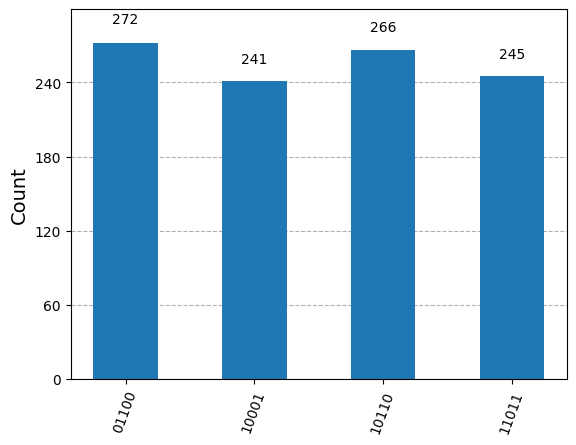

In [5]:
sampler = StatevectorSampler()

job = sampler.run([qc])

result = job.result()
counts = result[0].data.meas.get_counts()

print("simulated state :",counts)
print("desired state :",desired_states)
plot_histogram(counts)

#### different layouts available for optimization in `generate_preset_pass_manager` module

In [6]:
list_stage_plugins("layout")

['default', 'dense', 'sabre', 'trivial']

#### different routings available for optimization in `generate_preset_pass_manager` module

In [7]:
list_stage_plugins("routing")

['basic', 'lookahead', 'none', 'sabre', 'stochastic']

#### Try all the optimization to see the circuit depth for each. The given architecture is same as `FakeYorktownV2` 

In [8]:
routing_options = ['basic','sabre', 'stochastic']
layout_options = ['default', 'dense', 'sabre', 'trivial']
seed=10000

backend = FakeYorktownV2()

for i in range(4):
    pm = generate_preset_pass_manager(backend=backend, optimization_level=i, routing_method='basic', seed_transpiler=seed)
    pass_circuit = pm.run(qc)
    print(f"Circuit Depth for optimization level {i} is : {pass_circuit.depth()}")

for i in routing_options:
    pm = generate_preset_pass_manager(backend=backend, optimization_level=3, routing_method=i, seed_transpiler=seed)
    pass_circuit = pm.run(qc)
    print(f"Circuit Depth for {i} routing is : {pass_circuit.depth()}")

for i in layout_options:
    pm = generate_preset_pass_manager(backend=backend, optimization_level=3, layout_method=i, seed_transpiler=seed)
    pass_circuit = pm.run(qc)
    print(f"Circuit Depth for {i} layout is : {pass_circuit.depth()}")

Circuit Depth for optimization level 0 is : 95
Circuit Depth for optimization level 1 is : 96
Circuit Depth for optimization level 2 is : 96
Circuit Depth for optimization level 3 is : 96
Circuit Depth for basic routing is : 96
Circuit Depth for sabre routing is : 88
Circuit Depth for stochastic routing is : 99
Circuit Depth for default layout is : 88
Circuit Depth for dense layout is : 95
Circuit Depth for sabre layout is : 88
Circuit Depth for trivial layout is : 95


#### Taking the best optimized circuit from this and drawing it

Optimizal Circuit Depth is : 88


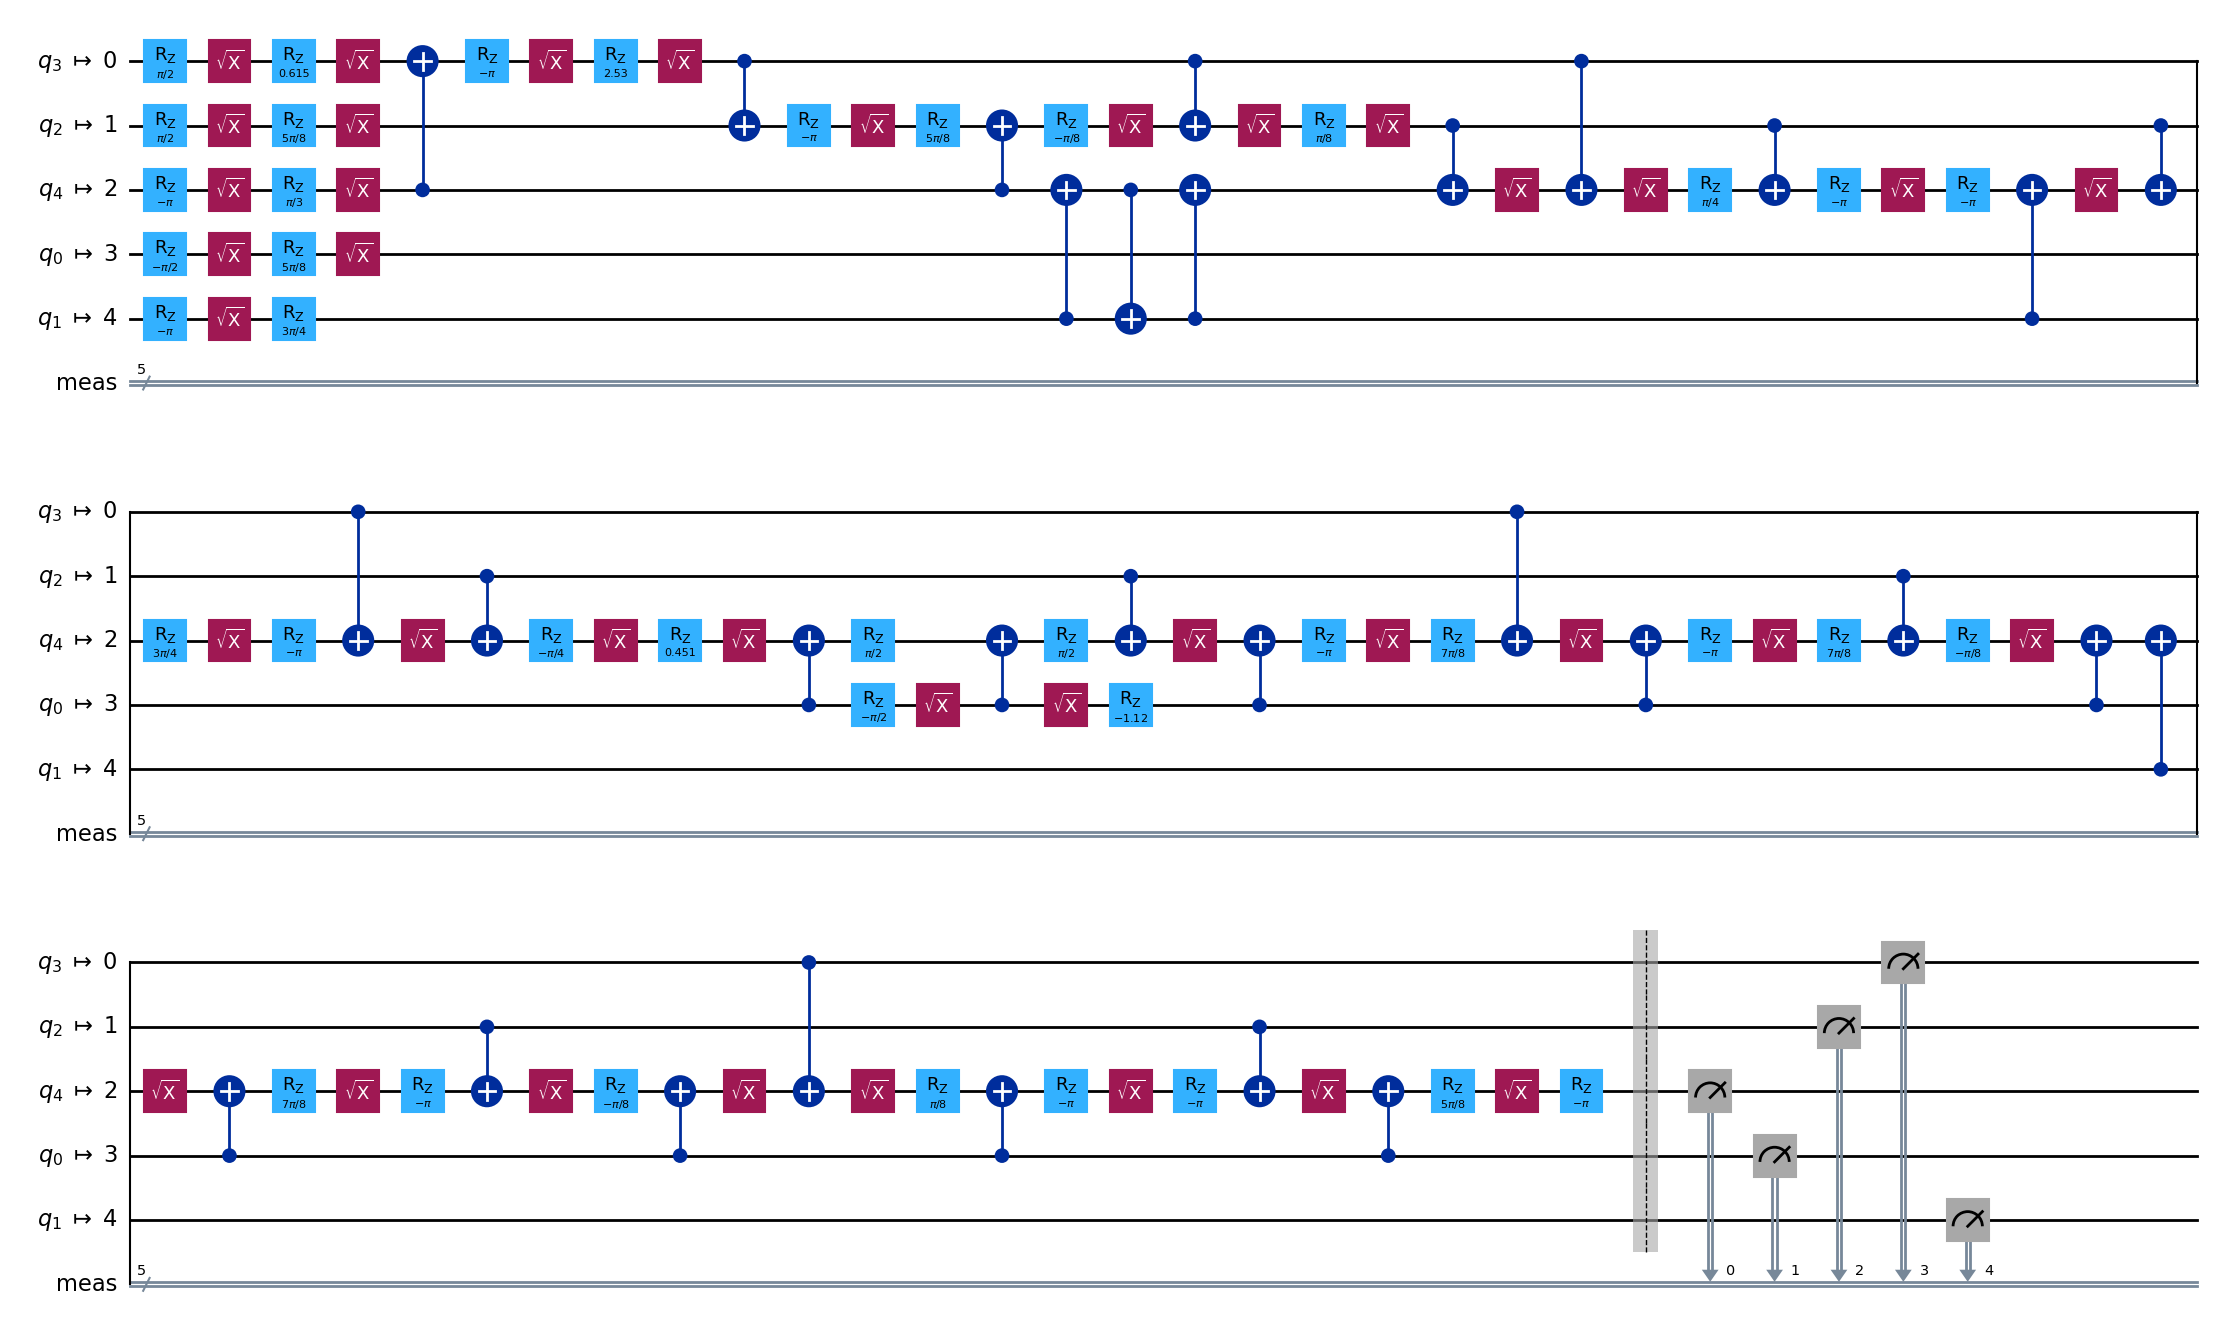

In [9]:
pm = generate_preset_pass_manager(backend=backend, optimization_level=3, layout_method='sabre' , routing_method='sabre', seed_transpiler=seed)
pass_circuit = pm.run(qc)
print(f"Optimizal Circuit Depth is : {pass_circuit.depth()}")
pass_circuit.draw('mpl', idle_wires=False, fold=32)

#### We can see the depth of this optimatized circuit is 88, which is still more than descried depth of 50 in the task.

#### check to see whether we can get the descried solution from this optimized circuit

simulated state : {'10001': 242, '11011': 260, '10110': 266, '01100': 256}
desired state : ['10110', '10001', '11011', '01100']


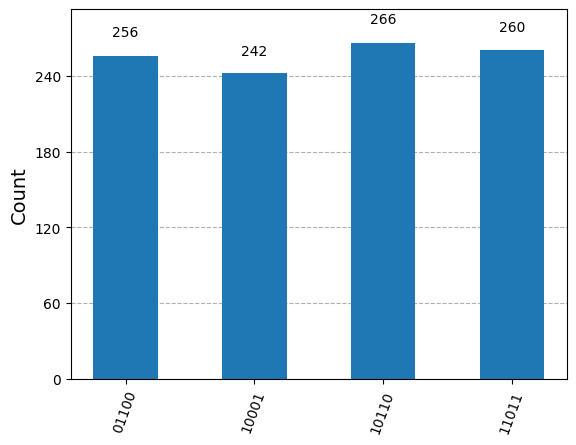

In [10]:
sampler = StatevectorSampler()
job = sampler.run([pass_circuit])

result = job.result()
counts = result[0].data.meas.get_counts()

print("simulated state :",counts)
print("desired state :",desired_states)
plot_histogram(counts)

#### Ploting the qubit potion of the architecture

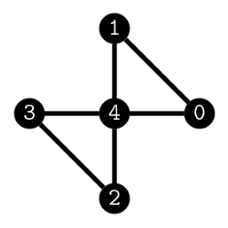

In [11]:
plot_circuit_layout(pass_circuit, backend)

#### Hence we will try another module `transpile` to see whether we can get mess depth

Optimizal Circuit Depth is : 89


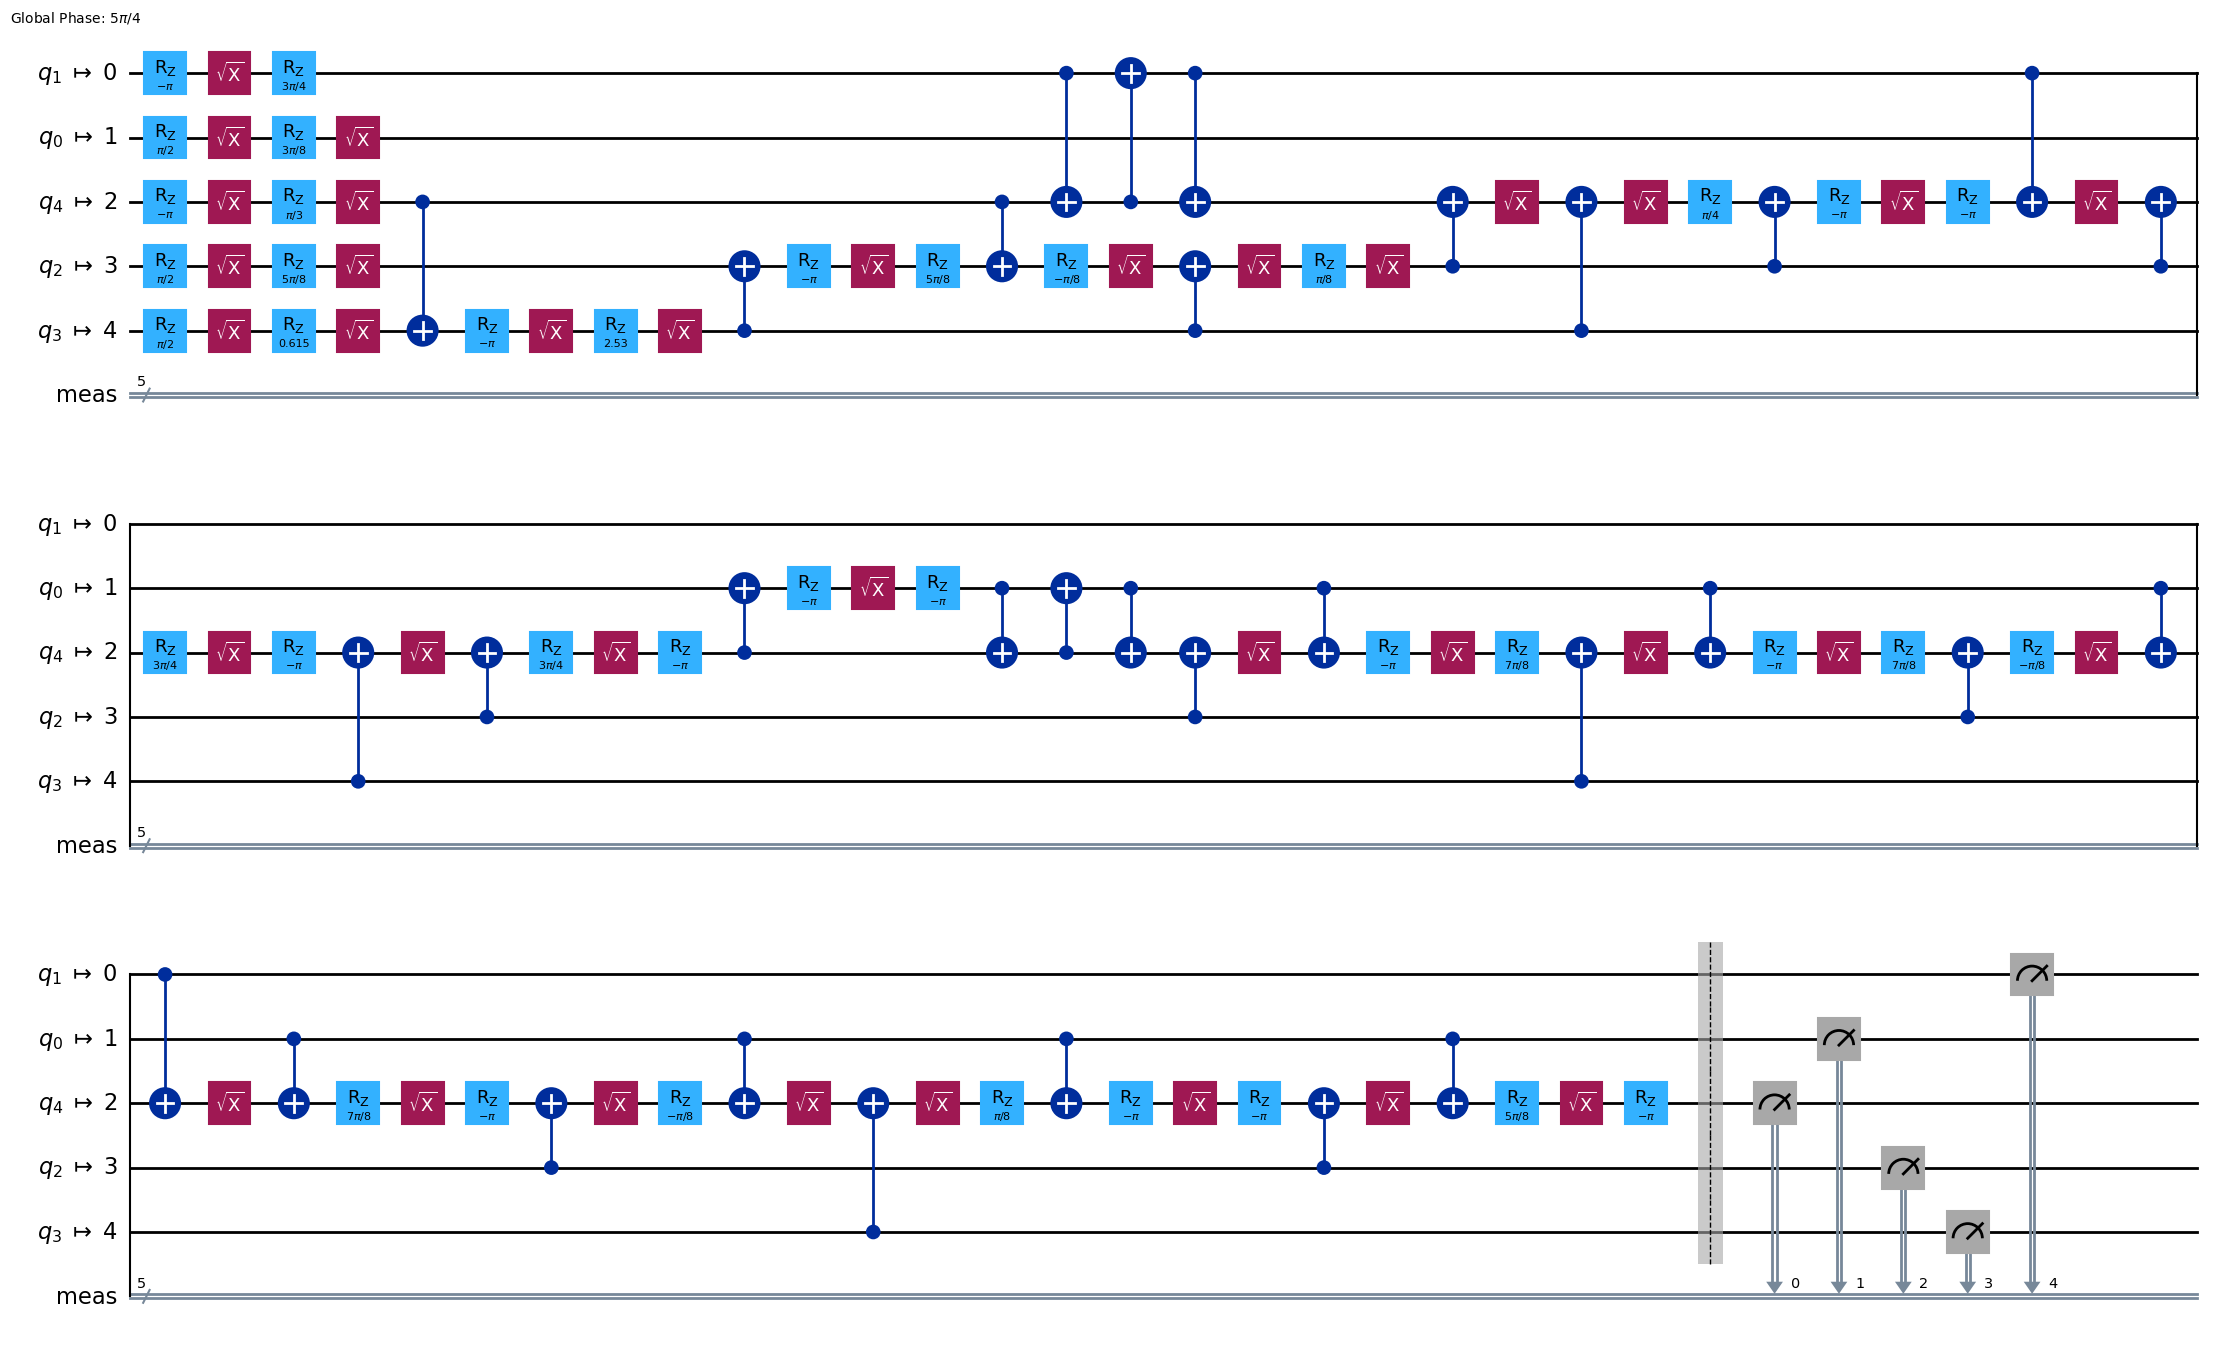

In [12]:
transpile_circuit = transpile(qc, backend, seed_transpiler=seed)
print(f"Optimizal Circuit Depth is : {transpile_circuit.depth()}")
transpile_circuit.draw('mpl', idle_wires=False, fold=32)

#### This method also doesnt five much depth improved.

#### check to see whether we can get the descried solution from this optimized circuit

simulated state : {'11011': 251, '10110': 241, '01100': 272, '10001': 260}
desired state : ['10110', '10001', '11011', '01100']


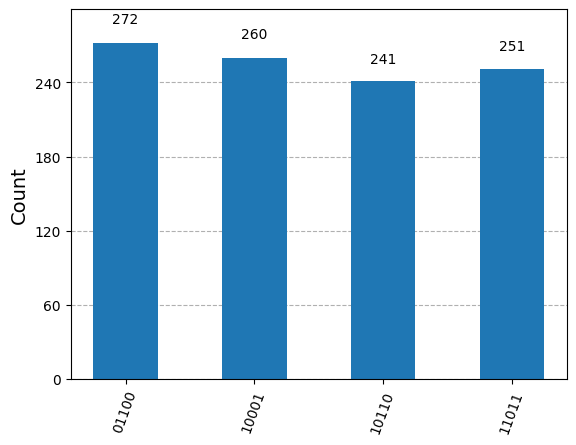

In [13]:
sampler = StatevectorSampler()
job = sampler.run([transpile_circuit])

result = job.result()
counts = result[0].data.meas.get_counts()

print("simulated state :",counts)
print("desired state :",desired_states)
plot_histogram(counts)

#### Ploting the qubit potion of the architecture

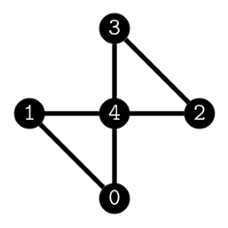

In [14]:
plot_circuit_layout(transpile_circuit, backend)